# Initialization

In [1]:
import os
import sys
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidatorModel


In [2]:
print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print(pyspark.__version__)

/Users/gaelleba/anaconda3/envs/sparkEnv/bin/python
3.5.4


# Start a SparkSession

In [3]:
# create a spark session
spark = SparkSession \
.builder \
.master("local") \
.config("spark.executor.memory", "8g") \
.config("spark.driver.memory", "8g") \
.config("spark.memory.fraction", "0.6") \
.config("spark.memory.storageFraction", "0.3") \
.config("spark.executor.cores", "4") \
.config("spark.sql.shuffle.partitions", "200") \
.config("spark.driver.extraJavaOptions", "-XX:ReservedCodeCacheSize=512m") \
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 22:41:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Open saved pre-treated data and models for binary classification

In [4]:
folder_models="binary_models_sample"

In [5]:
# Load the train and test DataFrames
train = spark.read.parquet(f"{folder_models}/train_full")
test = spark.read.parquet(f"{folder_models}/test_full")

# Show the schema of the DataFrames to verify they are loaded correctly
train.printSchema()
test.printSchema()

print("Features vector size:", train.select("features").head()[0].size)

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)

Features vector size: 801


In [ ]:
# Load the best models from the cross-validation
cvSVCmodel = CrossValidatorModel.load(f"{folder_models}/cvSVCmodel_fullEmbed")
cvRFmodel = CrossValidatorModel.load(f"{folder_models}/cvRFmodel_fullEmbed")
cvLRmodel = CrossValidatorModel.load(f"{folder_models}/cvLRmodel_fullEmbed")


# Verify the models are loaded correctly
print(cvSVCmodel)
print(cvRFmodel)
print(cvLRmodel)


CrossValidatorModel_40bbb67d55b5
CrossValidatorModel_cd455eb72158
CrossValidatorModel_1b0b96523b99


# Comparaison des modèles sur les données de test

In [ ]:
# Define the models
models = {
    'LinearSVM': cvSVCmodel,
    'RandomForest': cvRFmodel,
    'LogisticRegression': cvLRmodel
}

# Define the evaluators
evaluators = {
    'Accuracy': MulticlassClassificationEvaluator(metricName="accuracy"),
    'F1': MulticlassClassificationEvaluator(metricName="f1"),
    'ROC': BinaryClassificationEvaluator(metricName="areaUnderROC")
}

In [33]:
def evaluate_models(train, test, models, evaluators):
    results = []

    for model_name, model in models.items():
        # Collect the best parameters from the cross-validation results and fit on the entire training set
        best_model = model.getEstimator().copy(model.bestModel.extractParamMap())
        best_model = best_model.fit(train)

        # Make predictions on the test data
        predictions_train = model.transform(train)
        predictions_test = model.transform(test)
        
        # Evaluate the predictions
        for metric_name, evaluator in evaluators.items():
            metrics_train = {
                'Model': model_name,
                'Dataset': 'Train',
                'Metric': metric_name,
                'Value': evaluator.evaluate(predictions_train)
            }
            metrics_test = {
                'Model': model_name,
                'Dataset': 'Test',
                'Metric': metric_name,
                'Value': evaluator.evaluate(predictions_test)
            }
            
            # Store the results
            results.append(metrics_train)
            results.append(metrics_test)
            
        # Plot ROC curve
        roc_data = predictions_test.select("label", "rawPrediction").rdd.map(lambda row: (float(row["rawPrediction"][1]), float(row["label"]))).collect()
        roc_df = pd.DataFrame(roc_data, columns=["Probability", "Label"])
        roc_df = roc_df.sort_values(by="Probability", ascending=False)
        roc_df["TPR"] = roc_df["Label"].cumsum() / roc_df["Label"].sum()
        roc_df["FPR"] = (1 - roc_df["Label"]).cumsum() / (1 - roc_df["Label"]).sum()
        roc_auc = evaluators['ROC'].evaluate(predictions_test)
        # Plot the ROC curve
        plt.plot(roc_df['FPR'], roc_df['TPR'], label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', color='grey', label='Random Classifier (AUC = 0.5)')
    plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

/var/folders/ym/bgkz_f9x4f7dygsy5ydxzyb80000gn/T/ipykernel_26421/2796497108.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='grey', label='Random Classifier (AUC = 0.5)')


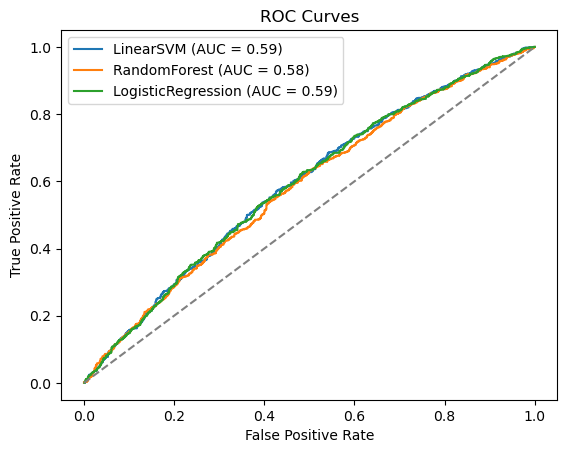

                 Model Dataset    Metric     Value
0            LinearSVM   Train  Accuracy  0.617442
1            LinearSVM    Test  Accuracy  0.565672
2            LinearSVM   Train        F1  0.614932
3            LinearSVM    Test        F1  0.563328
4            LinearSVM   Train       ROC  0.659712
5            LinearSVM    Test       ROC  0.591139
6         RandomForest   Train  Accuracy  0.711370
7         RandomForest    Test  Accuracy  0.564103
8         RandomForest   Train        F1  0.702049
9         RandomForest    Test        F1  0.548744
10        RandomForest   Train       ROC  0.810270
11        RandomForest    Test       ROC  0.582520
12  LogisticRegression   Train  Accuracy  0.614599
13  LogisticRegression    Test  Accuracy  0.567242
14  LogisticRegression   Train        F1  0.612267
15  LogisticRegression    Test        F1  0.565014
16  LogisticRegression   Train       ROC  0.657976
17  LogisticRegression    Test       ROC  0.590461


In [34]:
# Evaluate the models
results_df = evaluate_models(train, test, models, evaluators)
print(results_df)

In [36]:
results_df.to_csv(f"{folder_models}/results_sample_fullEmbed.csv", index=False)